In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class Neural_network_classifier:
    def __init__(self, hidden_layers, test_x, test_y, learning_rate=0.5, activation='tanh'):
        #Create own graph
        self.graph=tf.Graph()
        
        #Save test set
        self.test_x=test_x
        self.test_y=test_y
        
        #Find input and output size
        input_size=test_x.shape[1]
        output_size=test_y.shape[1]
        
        with self.graph.as_default():
            #Dimention of each layer of the net
            layer_dim=[input_size]+hidden_layers+[output_size]
            
            #x and y_true placeholders
            self.x = tf.placeholder(tf.float32, [None, input_size])
            self.y_true = tf.placeholder(tf.float32, [None, output_size])
            
            #Activations
            if activation == 'relu':
                g=tf.nn.relu
            elif activation == 'tanh':
                g=tf.nn.tanh
            elif activation == 'sigmoid':
                g=tf.nn.sigmoid
            
            #inputs, and outputs of each hidden layer 
            aes=[self.x] 
            
            #Parameters
            weights=[]
            biases=[]
            
            #hidden layers
            for i in range(len(layer_dim)-2):
                #Activation layers
                weights.append(tf.Variable(tf.random_uniform([layer_dim[i], layer_dim[i+1]], minval=-layer_dim[i]**-1, maxval=layer_dim[i]**-1)))
                biases.append(tf.Variable(tf.zeros([layer_dim[i+1]])))
                aes.append(g(tf.matmul(aes[-1],weights[-1])+ biases[-1]))
            
            #Softmax activation layer
            weights.append(tf.Variable(tf.random_uniform([layer_dim[-2], layer_dim[-1]], minval=-layer_dim[-2]**-1, maxval=layer_dim[-2]**-1)))
            biases.append(tf.Variable(tf.zeros([layer_dim[-1]])))
            logits=tf.matmul(aes[-1],weights[-1])+ biases[-1]
            
            if output_size>1:
                self.y_pred = tf.nn.softmax(logits)
            else:
                self.y_pred = logits
            
            #Cost and optimizer
            if output_size>1:
                cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=self.y_true)
            else:
                cross_entropy=tf.square(self.y_pred-self.y_true)
            self.cost = tf.reduce_mean(cross_entropy)
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.cost)
            
            #Calculate accuracy
            if output_size>1:
                correct_prediction = tf.equal(tf.argmax(self.y_pred, axis=1), tf.argmax(self.y_true, axis=1))
            else:
                correct_prediction = tf.equal(tf.round(self.y_pred), self.y_true)
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
            #Start a session and initialize variables
            self.sess=tf.Session()
            self.sess.run(tf.global_variables_initializer())
        
        #Errors after each training iteration
        self.train_errors=[]
        self.test_errors=[]
            
    def train_batch(self, x, y):
        feed_dict_train = {self.x: x, self.y_true: y}
        #run optimizer with x, y 
        self.sess.run(self.optimizer, feed_dict=feed_dict_train)
    
    def train_batches(self, num_iterations, batches):
        #train batch 0 and append it to X, Y
        X=np.array(batches[0][0])
        Y=np.array(batches[0][1])
        self.train_batch(batches[0][0], batches[0][1])
        for x, y in batches[1:]:
        #train batch (x, y) and append it to X, Y
            self.train_batch(x, y)
            X=np.concatenate((X,x))
            Y=np.concatenate((Y,y))
        #append errors after first iteration
        self.train_errors.append(self.sess.run(self.cost, feed_dict={self.x: X, self.y_true: Y}))
        self.test_errors.append(self.sess.run(self.cost, feed_dict={self.x: self.test_x, self.y_true: self.test_y}))
        
        #repeat for the remaining iterations
        for i in range(num_iterations-1):
            for (x, y) in batches:
                self.train_batch(x, y)
            self.train_errors.append(self.sess.run(self.cost, feed_dict={self.x: X, self.y_true: Y}))
            self.test_errors.append(self.sess.run(self.cost, feed_dict={self.x: self.test_x, self.y_true: self.test_y}))
        
    def split_batches(self, X, Y, batch_size):
        n=X.shape[0]
        num_batches=int(n/batch_size)
        batches=[]
        for i in range(num_batches):
            x=X[i*batch_size:(i+1)*batch_size]
            y=Y[i*batch_size:(i+1)*batch_size]
            batches.append((x,y))
        x=X[num_batches*batch_size:]
        y=Y[num_batches*batch_size:]
        batches.append((x,y))
        return batches
    
    def train(self, X, Y, batch_size, num_iterations):
        batches=self.split_batches(X, Y, batch_size)
        self.train_batches(num_iterations, batches)
    
    def print_accuracy(self):
        feed_dict_test = {self.x: self.test_x, self.y_true: self.test_y}
        acc = self.sess.run(self.accuracy, feed_dict=feed_dict_test)
        print("Accuracy on test set: "+str(acc))
    
    def plot_errors(self):
        plt.plot(self.train_errors)
        plt.plot(self.test_errors)
        plt.show()
        
    def predict(self, x):
        y_pred = self.sess.run(self.y_pred, feed_dict={self.x:x})
        if y_pred.shape[1]>1:
            return np.argmax(y_pred)
        else:
            return np.round(y_pred)

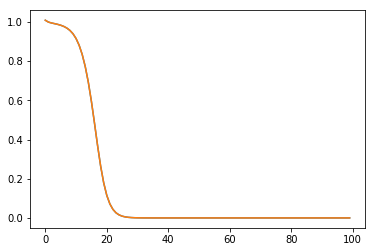

array([[ 1.],
       [-1.],
       [-1.],
       [ 1.]], dtype=float32)

In [2]:
#XOR problem
x=np.array([[-1,1], [-1,-1], [1,1], [1,-1]])
y=np.array([[1], [-1], [-1], [1]])
net=Neural_network_classifier([2], x, y, learning_rate=0.5, activation='tanh')
net.train(x, y, 4, 100)
net.plot_errors()
net.predict(x)

In [3]:
#MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
net2=Neural_network_classifier([], data.test.images, data.test.labels)
net2.train(data.train.images, data.train.labels, 1000, 5) #add more iterations for slightly better results
net2.print_accuracy()

Accuracy on test set: 0.9129


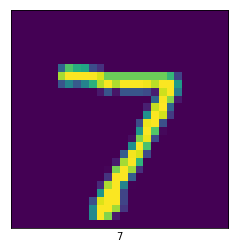

In [5]:
#Change the value of j to see different images and their classifications
j=0
plt.imshow(data.test.images[j].reshape([28,28]))
plt.xlabel(str(net2.predict([data.test.images[j]])))
plt.xticks([])
plt.yticks([])
plt.show()